# Basic - Two Model - Model Selection & Performance Evaluation

Exploratory Data Analysis, Preprocessing, and Feature Selection have been completed. Now with some effort trying to build a good model. Will also evaluate final performance metrics on a holdout.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white") # white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
import sklearn
import xgboost as xgb
from sklift.metrics import auqc, auuc, uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier

from pylift.eval import UpliftEval

%matplotlib inline

In [2]:
#will summarize the different model scores
def summarize_classification(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred, normalize=True)
    num_acc = accuracy_score(y_test, y_pred, normalize=False)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return {'accuracy': acc,
            'accuracy_count':num_acc,
           'precision':prec,
           'recall':recall,
           'roc_auc':roc_auc}

In [3]:
#helper to train the models
def build_model(classifier_fn,
               name_of_y_col,
               name_of_x_cols,
               dataset,
               test_frac=0.2,
               random_state_num=None):
    X = dataset[name_of_x_cols]
    Y = dataset[name_of_y_col]
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=test_frac,random_state=random_state_num)
     
    model = classifier_fn(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    y_pred_train = model.predict(x_train)
    
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)
    
    pred_results = pd.DataFrame({'y_test': y_test,
                                'y_pred': y_pred})
    
    model_crosstab = pd.crosstab(pred_results.y_pred,pred_results.y_test)
    
    return {'training': train_summary,
           'test': test_summary,
           'confusion_matrix': model_crosstab}

In [4]:
#helper to compare results across different models
def compare_results():
    for key in result_dict:
        print('Classification: ', key)
        print()
        
        print('Training data')
        
        for score in result_dict[key]['training']:
            print(score, result_dict[key]['training'][score])
        print()
        
        print('Test data')
        for score in result_dict[key]['test']:
            print(score, result_dict[key]['test'][score])
        print()

In [5]:
result_dict = {}

In [6]:
filepath = '/nas/isg_prodops_work/stemr/2020/2020_03 - Capstone Project/'
basic_df = pd.read_csv(filepath + 'opossum_sim_basic.csv')

In [7]:
#holdout for final performance eval
dev_df, holdout_df = train_test_split(basic_df, test_size=0.1)

In [8]:
holdout_df.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,response_cont,exposed,true_lift,response_cont_prior,conversion,conversion_post,segments
8915,0.0,0.0,1.0,1.0,-0.921714,-0.155380,2.182223,-0.500056,1.653736,-1.027680,-2.089581,0,0.000000,-2.089581,0,0,lost_cause
10826,1.0,0.0,0.0,0.0,-0.692579,0.629287,-1.140055,-1.234418,-1.624267,-1.428352,0.395584,0,0.000000,0.395584,0,0,lost_cause
42256,0.0,1.0,0.0,0.0,-3.801946,0.526863,-3.658212,-1.651734,0.862297,2.438731,-0.023024,1,0.763922,-0.786946,0,0,lost_cause
40498,0.0,0.0,1.0,1.0,2.871635,1.124607,1.676093,-1.066872,-0.209119,-0.060144,1.137797,0,0.000000,1.137797,1,1,sure_thing
6539,0.0,1.0,0.0,1.0,3.008747,0.570624,0.633750,2.490466,-1.931476,-0.210333,0.521348,0,0.000000,0.521348,1,1,sure_thing


From variable importance tests we are not going to include feature_0.

In [9]:
feature_names = list(dev_df.columns[1:10])
target_name = 'conversion_post'

In [10]:
# For two model approach break out in to two datasets one for exposed and one for not exposed
treatment_df = dev_df[dev_df['exposed'] == 1]
control_df = dev_df[dev_df['exposed'] == 0]

In [11]:
## Treatment Test Train Split
x = treatment_df[feature_names]
y = treatment_df[target_name]

x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(x, y, test_size=0.2)

In [12]:
y_train_t.value_counts()

1    13932
0     4052
Name: conversion_post, dtype: int64

In [13]:
#Gridcv for Logistic
params = {
    'C': [.001,.01,.2,.3,.5,.7,.9,1,3,5,10,50],
    'penalty': ['l1','l2']
}

logistic = LogisticRegression(solver='liblinear')

grid_search = GridSearchCV(logistic, param_grid=params, cv=5, return_train_score=True)
grid_search.fit(x_train_t,y_train_t)
grid_search.best_params_

{'C': 0.01, 'penalty': 'l1'}

In [14]:
#RandomCV for treatment xgboost
params = {
        'learning_rate' : [.02, .05, .08, .1, .15, .3, .6],
        'min_child_weight': [1, 3, 5, 8, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'subsample': [0.1, 0.4, 0.6, 0.8],
        'colsample_bytree': [0.3,0.6, 0.8],
        'max_depth': [2, 3, 4, 5, 6],
        'lambda': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'alpha': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'early_stopping_rounds' : [5,10,15],
        'scale_pos_weight' : [.25,1,3]
        }

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', silent=True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=120, cv=5,
                                   random_state=847, return_train_score=True, n_jobs = 10)
random_search.fit(x_train_t,y_train_t)
random_search.best_params_

{'subsample': 0.4,
 'scale_pos_weight': 1,
 'min_child_weight': 8,
 'max_depth': 4,
 'learning_rate': 0.15,
 'lambda': 5,
 'gamma': 7,
 'early_stopping_rounds': 5,
 'colsample_bytree': 0.6,
 'alpha': 0.5}

In [15]:
#default logistic
def logistic_fn(x_train, y_train):
    model = LogisticRegression(solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

In [16]:
#default randomforest
def randomforest_fn(x_train, y_train):
    model = RandomForestClassifier(n_estimators=200,max_depth=4)
    model.fit(x_train,y_train)
    
    return model

In [17]:
#Default xgb
def xgb_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic')
    model.fit(x_train,y_train)
    
    return model

In [18]:
#logistic tuned
def logistic_tuned_fn(x_train, y_train):
    model = LogisticRegression(solver='liblinear',C=0.01, penalty='l2')
    model.fit(x_train,y_train)
    
    return model

In [19]:
#tuned xgb
def xgb_tuned_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic', subsample=0.6, scale_pos_weight=1, min_child_weight = 10, 
                          max_depth = 5, learning_rate = 0.1, reg_lambda=0, gamma = 0.5, 
                          early_stopping_rounds=10,  colsample_bytree=0.8, reg_alpha = 5, silent=True)
    model.fit(x_train,y_train)
    
    return model

In [20]:
result_dict['converted ~ logistic'] = build_model(logistic_fn,
                                                target_name,
                                                feature_names,
                                                dataset=treatment_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ logistic_tuned'] = build_model(logistic_tuned_fn,
                                                target_name,
                                                feature_names,
                                                dataset=treatment_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ randomforest'] = build_model(randomforest_fn,
                                                target_name,
                                                feature_names,
                                                treatment_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier'] = build_model(xgb_fn,
                                                target_name,
                                                feature_names,
                                                treatment_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier_tuned'] = build_model(xgb_tuned_fn,
                                                target_name,
                                                feature_names,
                                                treatment_df,
                                                test_frac=0.2,
                                                random_state_num=847)

compare_results()

Classification:  converted ~ logistic

Training data
accuracy 0.7796930604982206
accuracy_count 14022
precision 0.7928193054738081
recall 0.9682288671650374
roc_auc 0.5518943942897878

Test data
accuracy 0.7883033133199912
accuracy_count 3545
precision 0.8038661008958039
recall 0.9660056657223796
roc_auc 0.5528063488901453

Classification:  converted ~ logistic_tuned

Training data
accuracy 0.7795262455516014
accuracy_count 14019
precision 0.7929896907216495
recall 0.9675819436457734
roc_auc 0.5523076712334958

Test data
accuracy 0.7894151656659996
accuracy_count 3550
precision 0.8049586776859504
recall 0.9657223796033995
roc_auc 0.5557670843208311

Classification:  converted ~ randomforest

Training data
accuracy 0.7736321174377224
accuracy_count 13913
precision 0.7736195295556915
recall 1.0
roc_auc 0.50012278978389

Test data
accuracy 0.7851901267511674
accuracy_count 3531
precision 0.7851423487544484
recall 1.0
roc_auc 0.500517063081696

Classification:  converted ~ xgb_classifier



In [21]:
## Treatment Test Train Split
x = control_df[feature_names]
y = control_df[target_name]

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.2)

In [22]:
y_train_c.value_counts()

0    9032
1    8983
Name: conversion_post, dtype: int64

In [23]:
#Gridcv for Logistic
params = {
    'C': [.001,.01,.2,.3,.5,.7,.9,1,3,5,10,50],
    'penalty': ['l1','l2']
}

logistic = LogisticRegression(solver='liblinear')

grid_search = GridSearchCV(logistic, param_grid=params, cv=5, return_train_score=True)
grid_search.fit(x_train_c,y_train_c)
grid_search.best_params_

{'C': 0.2, 'penalty': 'l1'}

In [24]:
#RandomCV for treatment xgboost
params = {
        'learning_rate' : [.02, .05, .08, .1, .15, .3, .6],
        'min_child_weight': [1, 2, 3, 5, 8],
        'gamma': [0, 0.5, 1, 1.5, 2, 5, 7],
        'subsample': [0.1, 0.4, 0.6, 0.8],
        'colsample_bytree': [0.3,0.6,0.7, 0.8],
        'max_depth': [2, 3, 4, 5, 6, 7],
        'lambda': [0, 0.5, 1, 1.5, 2, 5, 7],
        'alpha': [0, 0.5, 1, 1.5, 2, 5, 7],
        'early_stopping_rounds' : [10,15,20]
        }

xgb = XGBClassifier(objective='binary:logistic', silent=True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=120, cv=5,
                                   random_state=847, return_train_score=True, n_jobs = 10)
random_search.fit(x_train_c,y_train_c)
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 2,
 'learning_rate': 0.15,
 'lambda': 0,
 'gamma': 1,
 'early_stopping_rounds': 20,
 'colsample_bytree': 0.8,
 'alpha': 5}

In [25]:
#default logistic
def logistic_fn(x_train, y_train):
    model = LogisticRegression(solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

In [26]:
#default randomforest
def randomforest_fn(x_train, y_train):
    model = RandomForestClassifier(n_estimators=200,max_depth=4)
    model.fit(x_train,y_train)
    
    return model

In [27]:
#Default xgb
def xgb_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic')
    model.fit(x_train,y_train)
    
    return model

In [28]:
#logistic tuned
def logistic_tuned_fn(x_train, y_train):
    model = LogisticRegression(solver='liblinear',C=.02, penalty='l1')
    model.fit(x_train,y_train)
    
    return model

In [29]:
#tuned xgb
def xgb_tuned_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic', subsample=0.8, min_child_weight = 5, max_depth = 4,
                          learning_rate = 0.3, reg_lambda=1, gamma =7, early_stopping_rounds=15,  colsample_bytree=0.6, reg_alpha = 0.5, silent=True)
    model.fit(x_train,y_train)
    
    return model

In [30]:
result_dict['converted ~ logistic'] = build_model(logistic_fn,
                                                target_name,
                                                feature_names,
                                                dataset=control_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ logistic_tuned'] = build_model(logistic_tuned_fn,
                                                target_name,
                                                feature_names,
                                                dataset=control_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ randomforest'] = build_model(randomforest_fn,
                                                target_name,
                                                feature_names,
                                                control_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier'] = build_model(xgb_fn,
                                                target_name,
                                                feature_names,
                                                control_df,
                                                test_frac=0.2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier_tuned'] = build_model(xgb_tuned_fn,
                                                target_name,
                                                feature_names,
                                                control_df,
                                                test_frac=0.2,
                                                random_state_num=847)

compare_results()

Classification:  converted ~ logistic

Training data
accuracy 0.6913127948931446
accuracy_count 12454
precision 0.6928248649840185
recall 0.6938189845474614
roc_auc 0.6912981019889736

Test data
accuracy 0.702708703374778
accuracy_count 3165
precision 0.6950477845351868
recall 0.7152436298614215
roc_auc 0.7027916428971863

Classification:  converted ~ logistic_tuned

Training data
accuracy 0.6917013599777962
accuracy_count 12461
precision 0.6915009831767533
recall 0.6986754966887417
roc_auc 0.6916604730791559

Test data
accuracy 0.7020426287744227
accuracy_count 3162
precision 0.691977691977692
recall 0.7210549843540456
roc_auc 0.7021684273336173

Classification:  converted ~ randomforest

Training data
accuracy 0.6802109353316681
accuracy_count 12254
precision 0.682164549972391
recall 0.6817880794701987
roc_auc 0.6802016890929998

Test data
accuracy 0.6734014209591475
accuracy_count 3033
precision 0.6673951048951049
recall 0.6826106392489942
roc_auc 0.6734623553545369

Classification:

## Use winning models to make predictions and generate uplift score



In [31]:
pred_df = holdout_df.reset_index(drop=True)
x_pred_df = pred_df.iloc[:,1:10]

In [32]:
def xgb_tuned_fn_t(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic', subsample=0.6, scale_pos_weight=1, min_child_weight = 10, 
                          max_depth = 5, learning_rate = 0.1, reg_lambda=0, gamma = 0.5, 
                          early_stopping_rounds=10,  colsample_bytree=0.8, reg_alpha = 5, silent=True)
    model.fit(x_train,y_train)
    
    return model

#tuned xgb
def xgb_tuned_fn_c(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic', subsample=0.8, min_child_weight = 5, max_depth = 4,
                          learning_rate = 0.3, reg_lambda=1, gamma =7, early_stopping_rounds=15,  colsample_bytree=0.6, reg_alpha = 0.5, silent=True)
    model.fit(x_train,y_train)
    
    return model

xgb_t = xgb_tuned_fn_t(x_train_t,y_train_t)
xgb_c = xgb_tuned_fn_c(x_train_c,y_train_c)
pred_t = pd.DataFrame(xgb_t.predict_proba(x_pred_df)).iloc[:,1]
pred_c = pd.DataFrame(xgb_c.predict_proba(x_pred_df)).iloc[:,1]

In [33]:
pred_df['treatment_prediction'] = pred_t
pred_df['control_prediction'] = pred_c
pred_df['uplift_prediction'] = pred_df['treatment_prediction'] - pred_df['control_prediction'] 
pred_df['random_prediction'] = pd.DataFrame(np.random.uniform(-1,1,len(pred_df['conversion'])))

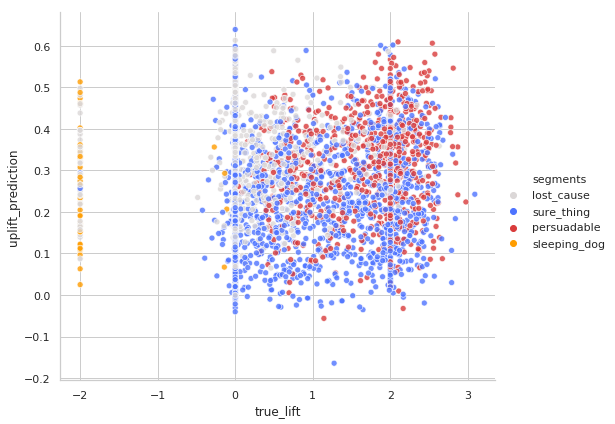

In [50]:
my_pal = {"sure_thing": "#4d73ff", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#ff9d00'}
sns.relplot(x="true_lift", y="uplift_prediction",
            hue="segments",palette=my_pal, data=pred_df, height=6, aspect=1.2, alpha=0.80);

## Performance Evaluation for Two Model

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f220088b400>,
      dtype=object)

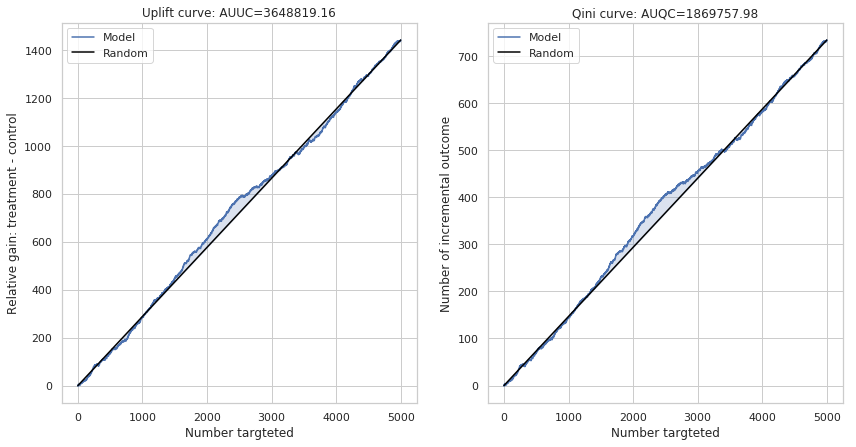

In [36]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['random_prediction'], treatment=pred_df['exposed'])

In [37]:
uplift_at_k(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'], k=0.3)

0.42528064277166794

In [38]:
auuc(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'])

4422370.143706777

In [39]:
auqc(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'])

2241539.3712944905

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f22008a4e48>,
      dtype=object)

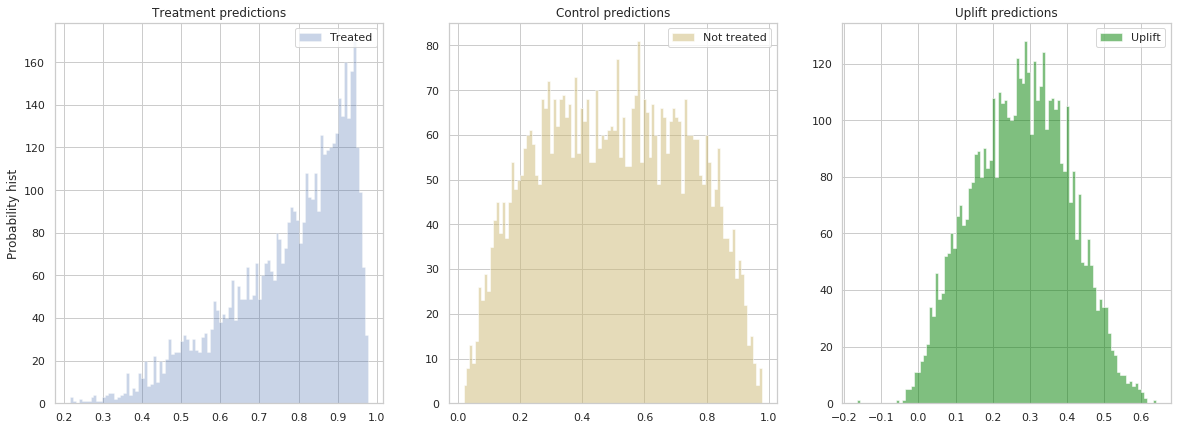

In [40]:
plot_uplift_preds(trmnt_preds=pred_df['treatment_prediction'], ctrl_preds=pred_df['control_prediction'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f220070a048>,
      dtype=object)

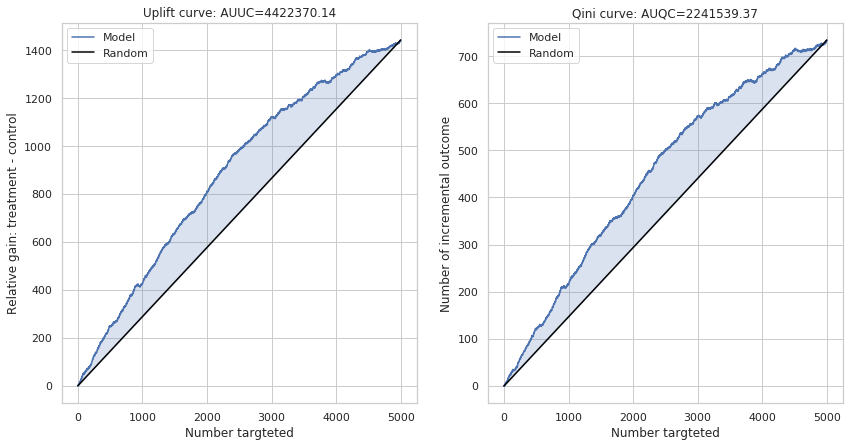

In [41]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'])

In [42]:
pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()

759

In [43]:
##Assumptions 
budget = 1000 #budget per 5,000 customers
conversion_profit = 100 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total)
prediction_df = pred_df[pred_df["exposed"] == 1].sort_values("uplift_prediction",ascending=False).head(treatment_total)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 250
Random ROI: $6,400
Model ROI: $10,900
Perfect ROI: $24,000
Improvement from random: 70.31%
Incremental conversions from random: 45
Model to perfect ratio: 45.42%


In [44]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

In [45]:
uplift1 = pred_df[pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['uplift_prediction'] <= pred_df['uplift_prediction'].quantile(q=.75))  & 
                  (pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['uplift_prediction'] <= pred_df['uplift_prediction'].quantile(q=.50))  &
                  (pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['uplift_prediction'] <= pred_df['uplift_prediction'].quantile(q=.25))  &
                  (pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

In [46]:
persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

In [47]:
persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

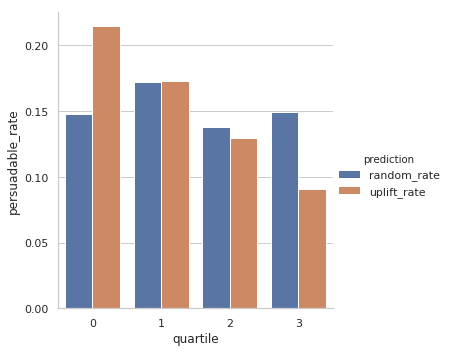

In [48]:
sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');